In [1]:
# config.py
from config import (
    ROSTER_SIZE,
    LEAGUE_SIZE,
    BONUS_PLAYER_POOL_MULT,
    G_SPLIT,
    W_SPLIT,
    B_SPLIT,
    SELECTED_COLUMNS,
    BREF_COLS,
    CORE_STATS,
    CAREER_STATS,
    COLOR_PALETTE,
    FANTASYPROS_URL,
    NAME_OVERRIDES,
)

# data_io.py
from data_io import (
    load_or_generate_data,
)

# data_cleaning.py
from data_cleaning import (
    clean_name,
    clean_and_refine_nba_data,
)

# feature_engineering.py
from feature_engineering import (
    bin_college,
    add_era_feature,
    parse_awards_cell,
    calculate_fantasy_points,
    calculate_productivity_score,
    calculate_years_since_peak,
    create_metrics,
)

# modeling.py
from modeling import (
    split_data_nba,
    create_baseline_nba,
    attach_model_results,
    tune_xgb_nba,
    create_model_nba,
    build_prediction_frame,
)

# data_viz.py
from data_viz import (
    plot_feature_importance,
    plot_actual_vs_pred,
    plot_resid_vs_pred,
    plot_resid_hist,
    plot_recent_seasons,
    plot_decile_calib,
)

# Standard libraries and external dependencies
import pandas as pd
import numpy as np
import unicodedata
import os
import re
from hyperopt import hp
import requests
from bs4 import BeautifulSoup
import warnings

# Create a data folder if not exists
if not os.path.exists('data'):
    os.makedirs('data')

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# TODO: Clean up formatting and organize imports as needed.
# TODO: Update process to accommodate scoring formats based on league rules
# TODO: Adjust the futurewarnings suppression placement so that it is not global.
# TODO: Add in bootstrapping pipeline to identify player implied upside opportunities.
# TODO: Update pred vs actual visual to include regression line

In [3]:
# Setting input variables
START_YEAR = 2000
END_YEAR = 2024
PRED_YEAR = END_YEAR + 1

# Defining player pool sizes for each position group
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
g_pool = round(player_pool * G_SPLIT, 0)
w_pool = round(player_pool * W_SPLIT, 0)
b_pool = round(player_pool * B_SPLIT, 0)

In [4]:
api_df, bref_df = load_or_generate_data(START_YEAR, END_YEAR)

Loaded existing API data from CSV file.
Loaded existing BRef data from CSV file.


In [5]:
api_df = clean_and_refine_nba_data(api_df)
bref_df = clean_and_refine_nba_data(bref_df)

# Keep only selected columns for the model
api_df = api_df[SELECTED_COLUMNS]
bref_df = bref_df[BREF_COLS]

In [6]:
# Merging dataframes together
## Protip, "ws" values will be null for players that did not match correctly on name and year
combined_df = pd.merge(
    api_df,
    bref_df,
    on=["player_name_clean", "year"],
    how="left",
    suffixes=("", "_bref"),
)

# If duplicate columns appear in the dataset, keep only the first occurrence
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

# Drop rows where a player's team information is missing
combined_df = combined_df[combined_df["team"].notna()]

# Sort the dataframe by player name clean & year
combined_df = combined_df.sort_values(by=["player_name_clean", "year"]).reset_index(drop=True)

# Insert the team & ws columns to be placed after the year column for reference
combined_df.insert(
    combined_df.columns.get_loc("year") + 1,
    "team",
    combined_df.pop("team"),
)
combined_df.insert(
    combined_df.columns.get_loc("year") + 2,
    "ws",
    combined_df.pop("ws"),
)

In [7]:
# Calculating fantasy points for each season
combined_df = calculate_fantasy_points(combined_df)
# Calculating productivity score metrics
combined_df = calculate_productivity_score(combined_df, age_col='age')
# Calculating years since each player's peak season
combined_df = calculate_years_since_peak(combined_df)
# Stating the era each season belongs to
combined_df = add_era_feature(combined_df)

In [8]:
awards_parsed = combined_df["awards"].apply(parse_awards_cell)

awards_df = pd.DataFrame(list(awards_parsed), index=combined_df.index)

combined_df = pd.concat([combined_df, awards_df], axis=1)

# Dropping the original Awards column
combined_df = combined_df.drop(columns=["awards"])

# Binning colleges into 'pipeline', 'notable', and 'other' categories
combined_df = bin_college(
    combined_df,
    college_col="college",
    player_col="player_name_clean",
    pipeline_threshold=10,  # >10 players = pipeline
    notable_threshold=3,    # >3 players = notable
)
# Dropping the original college column
combined_df = combined_df.drop(columns=["college"])

In [9]:
# Adding additional aggregated metrics for core statistics
combined_df = create_metrics(combined_df, CORE_STATS, CAREER_STATS)

# Creating age based features
combined_df["years_in_league"] = combined_df["year"] - combined_df["rookie_year"]
combined_df["age_bucket"] = pd.cut(
    combined_df["age"],
    bins=[18, 22, 26, 30, 34, 45],
    labels=["rookie", "young", "prime", "veteran", "late"],
)
# Adding feature that concatenates age bucket and player_tier
combined_df["age_tier"] = (
    combined_df["age_bucket"].astype("string")
    + "_"
    + combined_df["player_tier"].astype("string")
).astype("category")

# Creating feature to identify COVID-impacted season
combined_df["covid_flag"] = np.where(combined_df["year"] == 2020, 1, 0)
# Creating feature to identify post-COVID season (2021) due to limited games in 2020
combined_df["post_covid_flag"] = np.where(combined_df["year"] == 2021, 1, 0)

# Add incomplete_career_history flag to identify players that are missing a full capture of playing history
combined_df["incomplete_career_history"] = (
    (combined_df["rookie_year"] < (START_YEAR))
    | (
        (combined_df["college_bin"] == "no_college")
        & (combined_df["age"] >= 25)
        & (combined_df["year"] == (START_YEAR + 1))
    )
).astype(int)
# Setting each player's incomplete_career_history flag to 1 if any season is marked as incomplete
combined_df["incomplete_career_history"] = (
    combined_df.groupby("player_name_clean")["incomplete_career_history"].transform("max")
)

# Creating feature to identify career eligble games played
combined_df["eligible_games_played"] = combined_df["career_gp"] / (82 * (combined_df["years_in_league"] + 1))
# Dropping career_gp column as it's no longer needed
combined_df = combined_df.drop(columns=["career_gp"])
# Adding 3 year average of eligible games played to emphasize recent availability
combined_df["avg3yr_eligible_games_played"] = combined_df.groupby("player_name_clean")["eligible_games_played"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Creating a feature to indicate whether a player was significantly injured during a season
combined_df["injury_flag"] = np.where(
    (combined_df["gp"] < 60) & (combined_df["min_pg"] >= 15), 1, 0
)
# Adding a 3 year average of injury flag to indicate frequency of injuries
combined_df["avg3yr_injury_flag"] = combined_df.groupby("player_name_clean")["injury_flag"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
# Adding cumulative sum career total of injury seasons
combined_df["career_injury_seasons"] = combined_df.groupby("player_name_clean")["injury_flag"].cumsum()

# Adding features to calculate fantasy points per minute and per game
combined_df["fpts_per_gp"] = combined_df["fantasy_points"] / combined_df["gp"].replace(0, np.nan)
combined_df["fpts_per_min"] = combined_df["fantasy_points"] / combined_df["mp"].replace(0, np.nan)
# Adding 3 year trends for fpts per game and per minute
combined_df['fpts_per_gp_3yr'] = combined_df['sum3yr_fantasy_points'] / combined_df['sum3yr_gp'].replace(0, np.nan)
combined_df['fpts_per_min_3yr'] = combined_df['sum3yr_fantasy_points'] / combined_df['sum3yr_mp'].replace(0, np.nan)

# Adding minutes per game and usage percentage growth trends
combined_df["min_pg_growth_recent"] = combined_df["min_pg"] - combined_df["avg3yr_min_pg"]
combined_df["usg_growth_recent"] = combined_df["usg_pct"] - combined_df["avg3yr_usg_pct"]
# Adding points per game per usage percentage (how effective are they with their usage)
combined_df["pts_per_usg"] = combined_df["pts_pg"] / combined_df["usg_pct"].replace(0, np.nan)

# Age-curve interaction 
combined_df["age_x_bpm"] = combined_df["age"] * combined_df["bpm"]
combined_df["age_x_min_pg"] = combined_df["age"] * combined_df["min_pg"]

# Minutes headroom (upside proxy for young players)
combined_df["min_pg_headroom"] = 36 - combined_df["min_pg"]

# Consistency / volatility
combined_df["fpts_std_3yr"] = (
    combined_df.groupby("player_name_clean")["fantasy_points"]
    .transform(lambda x: x.rolling(3, min_periods=2).std())
)

# Year-over-year momentum
combined_df["fpts_yoy_pct_change"] = (
    combined_df.groupby("player_name_clean")["fantasy_points"]
    .pct_change()
)

# Playoff experience flag
combined_df["has_playoff_exp"] = (combined_df["career_playoff_pts"] > 0).astype(int)

# Flag to denote starters based on minutes per game
combined_df["starter_proxy"] = (combined_df["min_pg"] >= 25).astype(int)

# Draft capital decay
combined_df["pk_adj"] = np.where(
    combined_df["years_in_league"] <= 4,
    combined_df["pk"],
    np.nan  # or 61 as "irrelevant"
)

In [10]:
# # Fixing up columns that need to be reformatted for modeling
combined_df["pos"] = combined_df["pos"].astype("category")
combined_df["team"] = combined_df["team"].astype("category")

In [11]:
# Displaying combined_df sorted by player name & year
combined_df = combined_df.sort_values(by=["player_name_clean", "year"]).reset_index(drop=True)
display(combined_df)

,player_id,player_name_clean,season,year,team,ws,age,pts,reb,ast,...,usg_growth_recent,pts_per_usg,age_x_bpm,age_x_min_pg,min_pg_headroom,fpts_std_3yr,fpts_yoy_pct_change,has_playoff_exp,starter_proxy,pk_adj
0,201166,aaron brooks,2007-08,2008,HOU,1.4,23.0,264,56,87,...,0.000000,106.944444,-4.6,274.196078,24.078431,NaN,NaN,0,0,26.0
1,201166,aaron brooks,2008-09,2009,HOU,3.6,24.0,894,157,238,...,0.005000,105.309735,-21.6,599.400000,11.025000,710.430183,2.129955,1,0,26.0
2,201166,aaron brooks,2009-10,2010,HOU,5.5,25.0,1604,215,434,...,0.022000,110.236220,17.5,889.939024,0.402439,1029.246807,0.713628,1,1,26.0
3,201166,aaron brooks,2010-11,2011,2TM,1.1,26.0,634,78,233,...,0.007333,100.000000,-78.0,565.830508,14.237288,745.683921,-0.569526,1,0,26.0
4,201166,aaron brooks,2012-13,2013,2TM,0.8,28.0,376,80,114,...,-0.049667,108.426966,-61.6,526.716981,17.188679,965.597951,-0.360940,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9033,980,zydrunas ilgauskas,2006-07,2007,CLE,6.6,32.0,925,599,123,...,-0.018333,106.976744,12.8,873.846154,8.692308,307.053812,-0.125283,1,1,NaN
9034,980,zydrunas ilgauskas,2007-08,2008,CLE,6.1,33.0,1029,682,104,...,-0.002667,109.777778,-13.2,1004.465753,5.561644,155.234156,0.096504,1,1,NaN
9035,980,zydrunas ilgauskas,2008-09,2009,CLE,5.6,34.0,838,490,64,...,0.010667,108.898305,-10.2,923.230769,8.846154,284.611741,-0.241332,1,1,NaN
9036,980,zydrunas ilgauskas,2009-10,2010,CLE,2.5,35.0,474,345,48,...,-0.029000,99.465241,-133.0,732.265625,15.078125,621.611980,-0.384050,1,0,NaN


# Modeling

## Defining training & testing datasets

In [12]:
def sanitize_dtypes(X: pd.DataFrame) -> pd.DataFrame:
    """
    Sanitize pandas dtypes for packages (notably XGBoost) that choke on
    pandas StringDtype-backed categoricals (e.g., categories dtype 'string[python]').

    - Converts pandas StringDtype columns -> object
    - Forces category columns to be object-backed categories
    - Leaves numeric columns untouched
    """
    out = X.copy()

    # Convert pandas StringDtype columns to plain object
    string_cols = out.select_dtypes(include=["string"]).columns
    for c in string_cols:
        out[c] = out[c].astype(object)

    # Force categoricals to have object categories (avoid 'string[python]' categories)
    cat_cols = out.select_dtypes(include=["category"]).columns
    for c in cat_cols:
        out[c] = out[c].astype(object).astype("category")

    return out

In [13]:
# Sanitize the full modeling frame before split
combined_df = sanitize_dtypes(combined_df)

In [42]:
# Splitting the data into training, testing, and validation sets
X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = split_data_nba(combined_df, PRED_YEAR, random_state=121994)

# Scaling is not explicitly required for tree-based models, but keeping the process for potential future use
# X_train, X_test, scaler = scale_numeric_train_test(X_train, X_test)

## Creating Baseline Model

In [43]:
# Generating baseline model and predictions to measure final model performance
baseline_model, baseline_pred = create_baseline_nba(X_train, X_test, y_train, y_test)

[Baseline] RMSE: 434.383
[Baseline] MAE:  329.889
[Baseline] R^2:  0.716


In [44]:
# Attach baseline model results to testing set for review
results = attach_model_results(X_test, baseline_pred, combined_df)

display(results)

,player_name_clean,season,year,age,fantasy_points,prediction_diff,fantasy_points_future,predicted_fantasy_points
5017,kevin garnett,2000-01,2001,25.0,4028.7,-166.74,3961.2,3794.462402
5003,kevin durant,2010-11,2011,22.0,3395.6,660.87,3075.9,3736.767090
3710,james harden,2014-15,2015,25.0,3936.3,-369.81,4091.2,3721.393555
3711,james harden,2015-16,2016,26.0,4091.2,-833.44,4520.3,3686.863281
5624,luka doncic,2022-23,2023,24.0,3747.3,-728.38,4304.4,3576.023682
...,...,...,...,...,...,...,...,...
4333,joel freeland,2013-14,2014,27.0,541.6,-215.28,495.2,279.923279
7587,sam mitchell,2000-01,2001,37.0,590.1,-153.81,431.9,278.094238
7700,semih erden,2010-11,2011,24.0,417.6,36.65,227.9,264.554840
3243,greg foster,2000-01,2001,32.0,345.4,-4.02,262.9,258.878387


## Creating Final Model

In [45]:
# Building a prediction dataframe and feature predictions dataframe
pred_df, X_pred = build_prediction_frame(
    combined_df,
    pred_year=PRED_YEAR,
    feature_cols=feature_cols,
)

In [46]:
# Define Hyperopt search space for final model tuning
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.004), np.log(0.15)),

    # leaf-based complexity control
    "max_leaves": hp.quniform("max_leaves", 8, 56, 1),

    "subsample": hp.uniform("subsample", 0.85, 0.95),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 0.95),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(0.1), np.log(30.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-3), np.log(6.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(6.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-3), np.log(3.0)),
}

# Tune Model
best_params = tune_xgb_nba(
    X_train,
    X_val,
    y_train,
    y_val,
    space=space,
    metric="rmse",
    evals=50,
)

final_model, final_pred = create_model_nba(
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    final_params=best_params,
)

100%|██████████| 50/50 [03:46<00:00,  4.53s/trial, best loss: 415.4497581491324]
Best Parameters: {'learning_rate': 0.006059911263333662, 'max_leaves': 27, 'grow_policy': 'lossguide', 'subsample': 0.9291176562394675, 'colsample_bytree': 0.8112685877623484, 'min_child_weight': 21.954244269325745, 'reg_lambda': 0.8725216225099155, 'reg_alpha': 2.509711373121712, 'gamma': 0.22981212908362753}
[Best trial @ val] optimized=rmse | RMSE=415.450 | MAE=314.752 
Best iteration: 1322
[Val] RMSE: 413.825 | MAE: 313.568 | R^2: 0.742
[Test] RMSE: 415.758 | MAE: 315.135 | R^2: 0.750


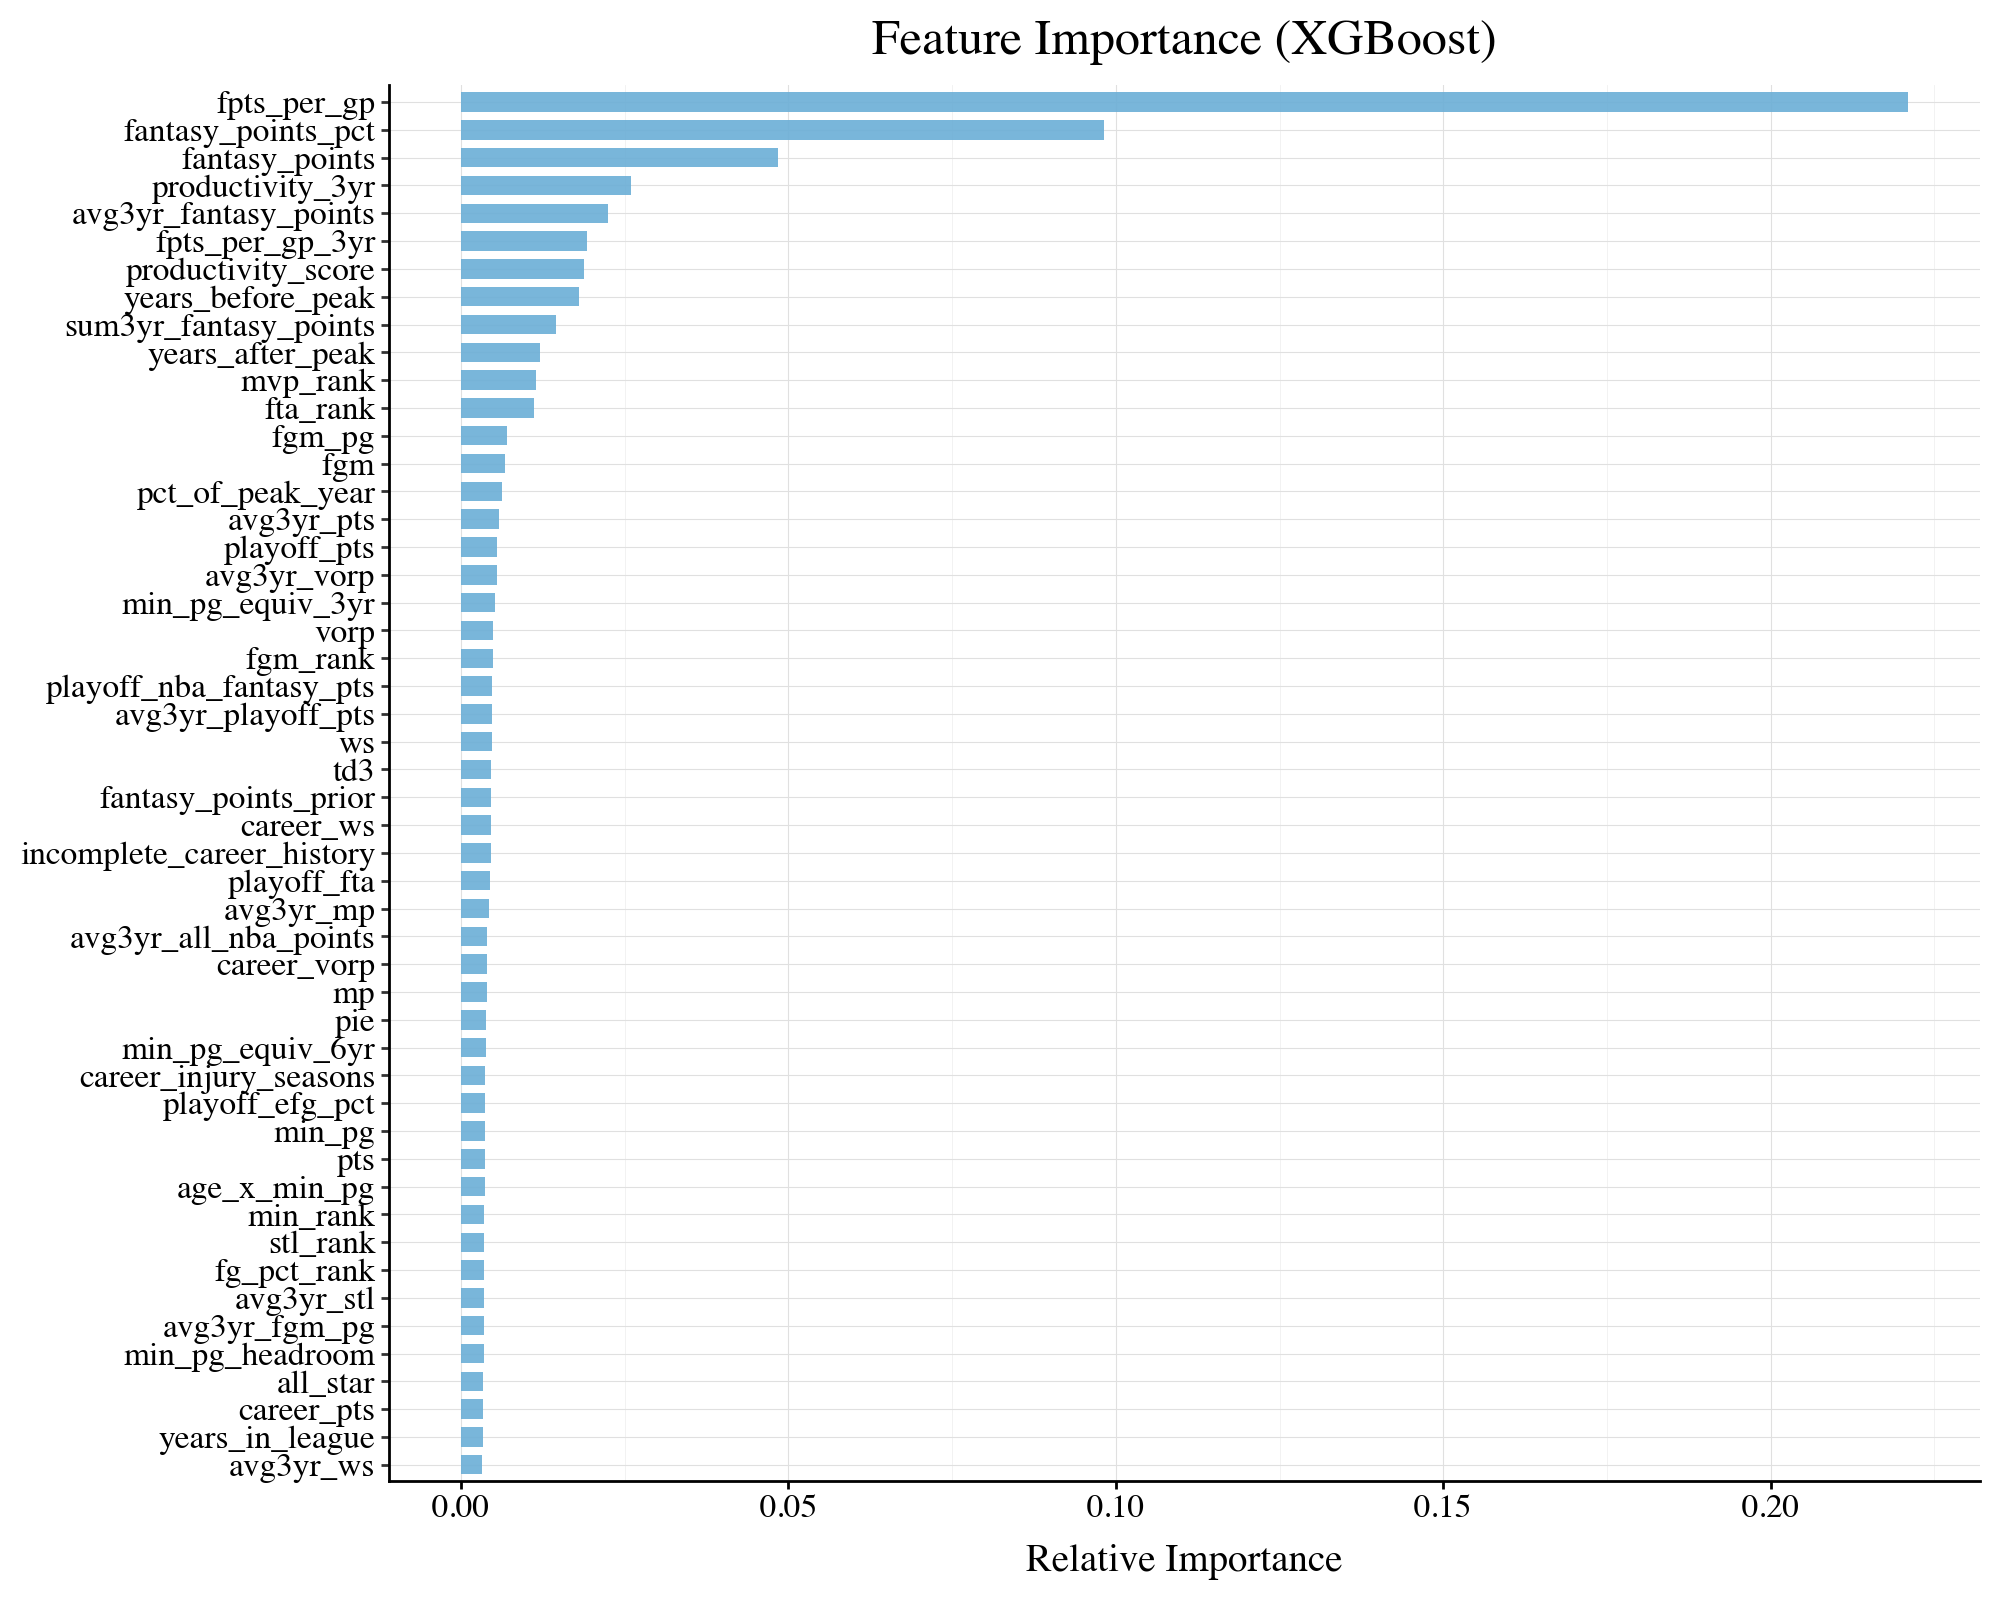

In [ ]:
# Plotting out the feature importance of the final model
plot_feature_importance(
    final_model,
    X_train=X_train,  # your training feature frame
    top_n=25,
    importance_type="gain",
).show()

In [48]:
# Attach final model results to validation set for review
results = attach_model_results(X_val, final_pred, combined_df)

display(results)

,player_name_clean,season,year,age,fantasy_points,prediction_diff,fantasy_points_future,predicted_fantasy_points
5497,lebron james,2008-09,2009,24.0,4369.1,-264.12,4244.3,3980.177490
5498,lebron james,2009-10,2010,25.0,4244.3,41.30,3888.0,3929.301514
7750,shai gilgeous alexander,2023-24,2024,25.0,3938.5,-284.55,4108.8,3824.253662
2589,dwight howard,2009-10,2010,24.0,3652.4,-64.25,3862.1,3797.848145
5018,kevin garnett,2001-02,2002,26.0,3961.2,-714.45,4444.9,3730.454834
...,...,...,...,...,...,...,...,...
4702,jud buechler,2000-01,2001,33.0,430.3,-61.22,370.2,308.980896
7716,sergey karasev,2014-15,2015,21.0,349.2,85.31,221.1,306.411560
7150,rayan rupert,2023-24,2024,20.0,372.4,-11.25,306.5,295.250183
2463,donell taylor,2005-06,2006,23.0,339.1,-5.51,292.1,286.587921


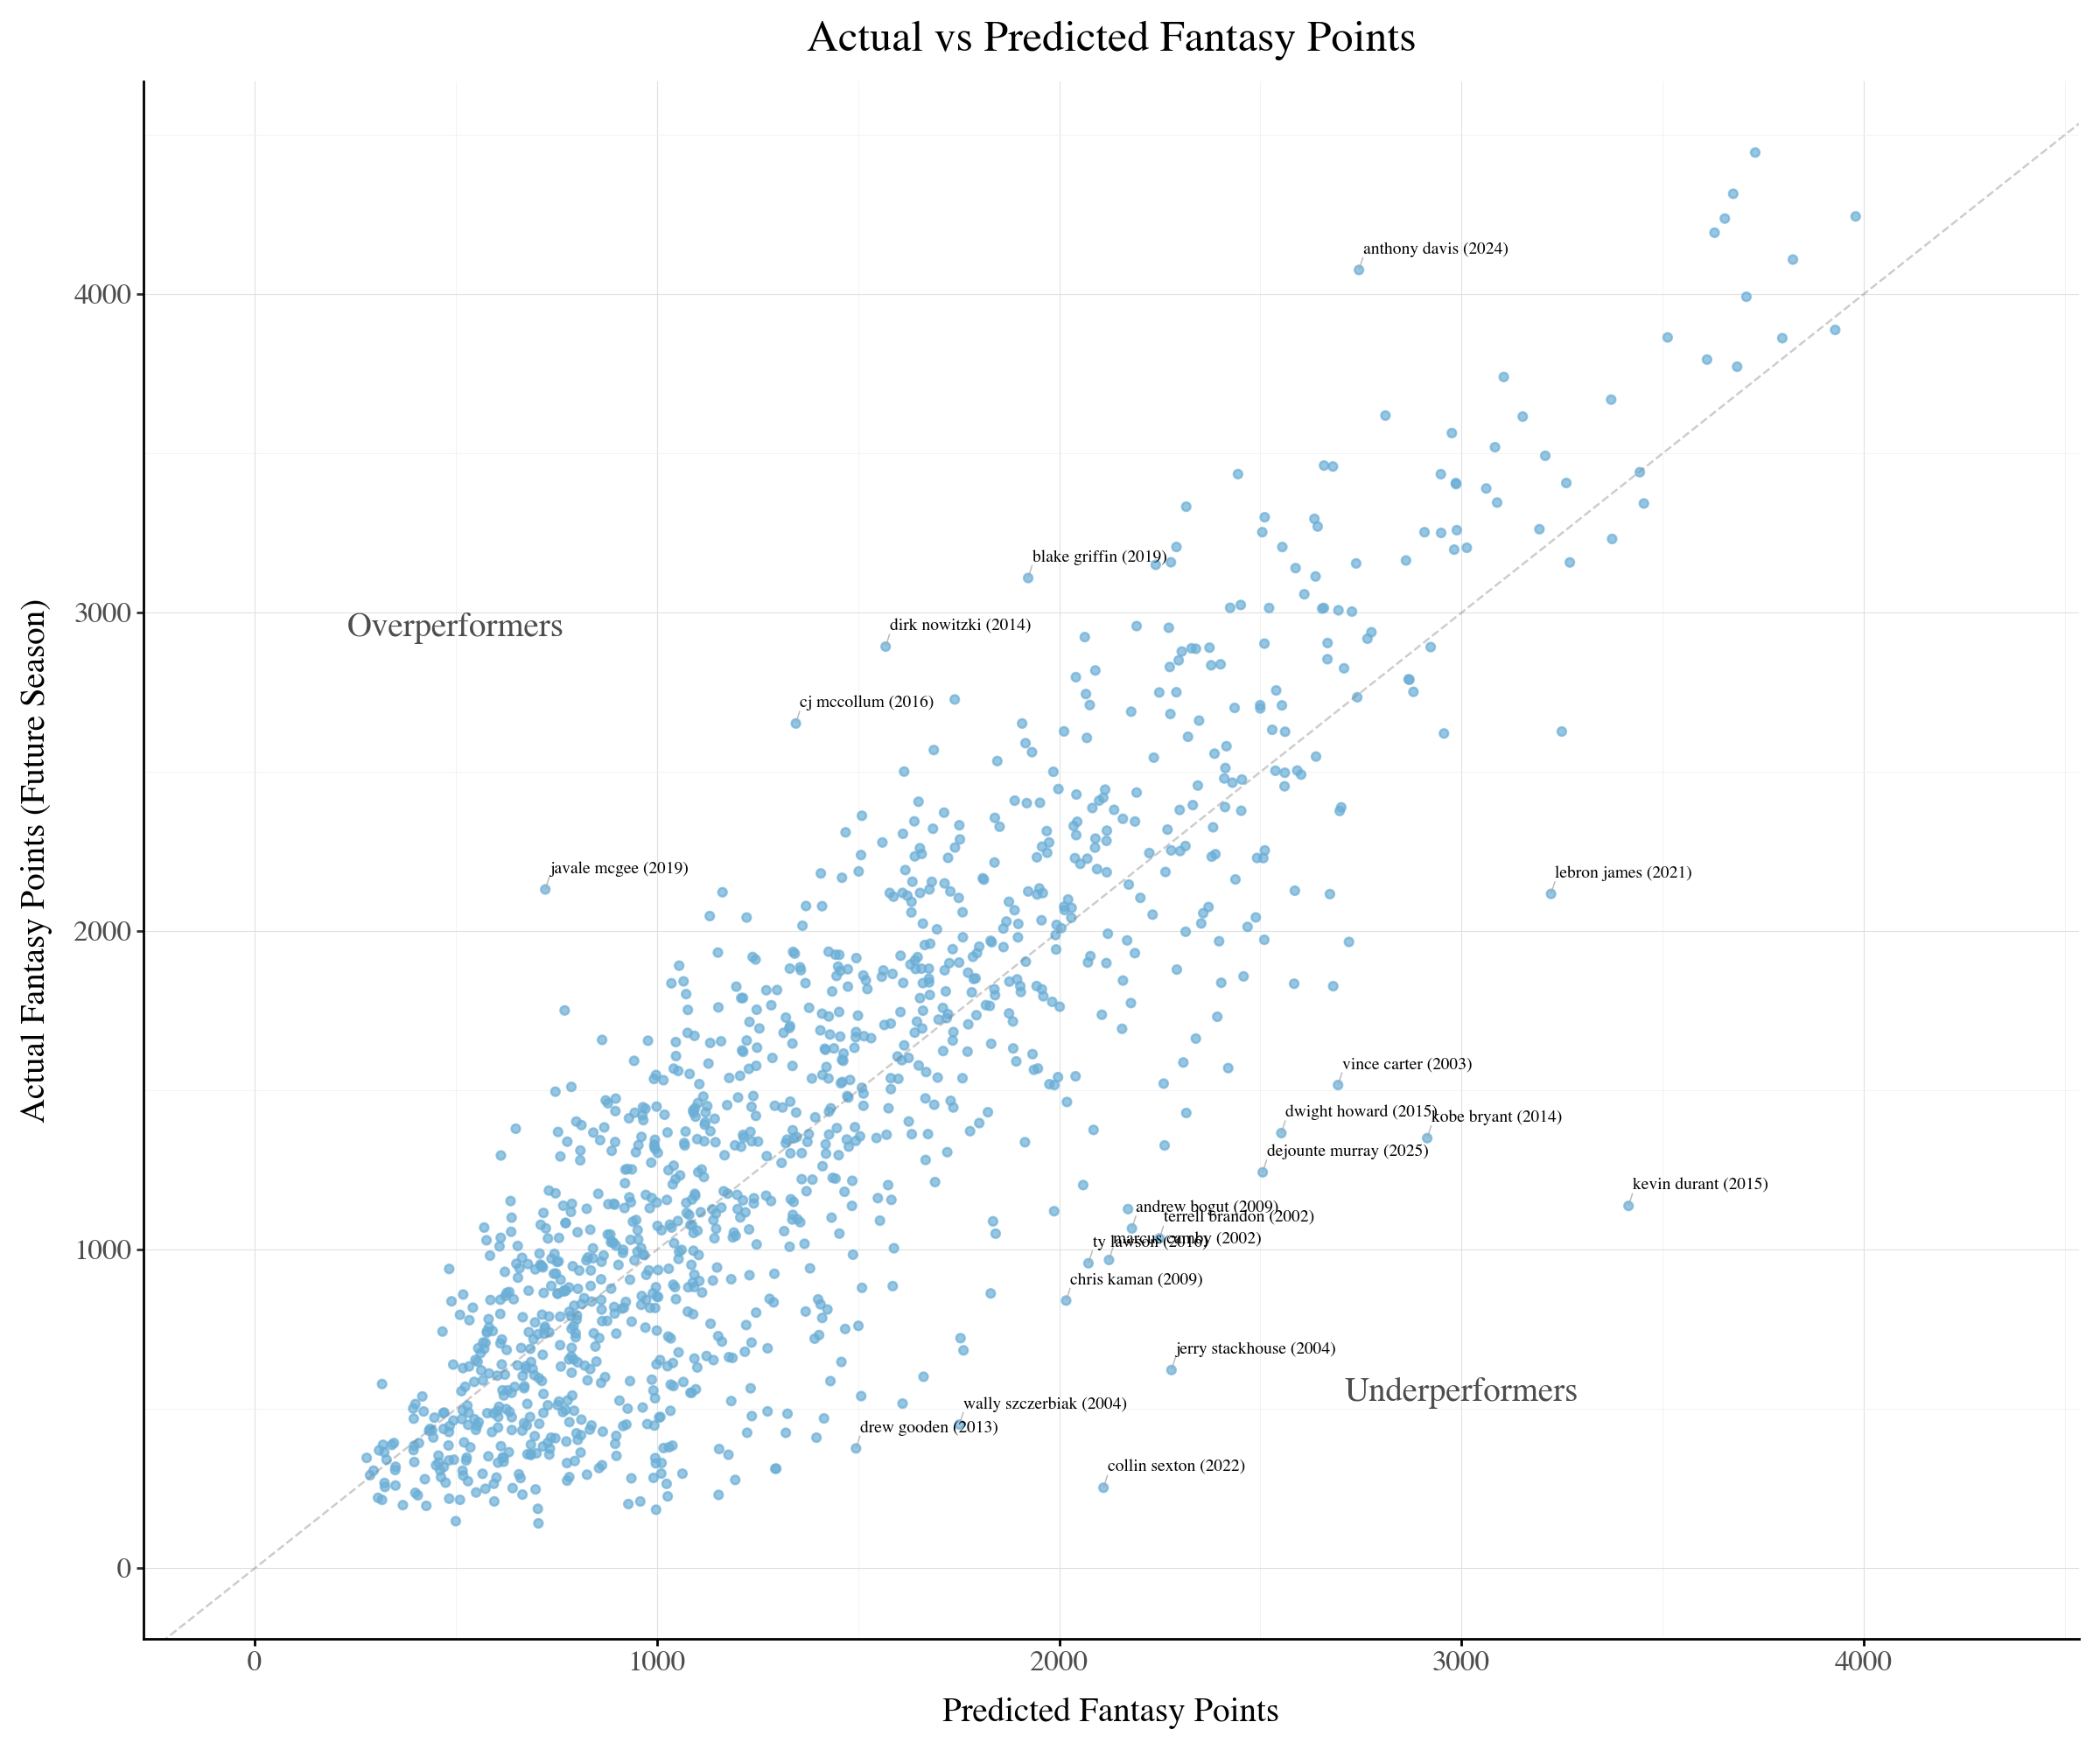

In [49]:
## Plot for Actual vs Predicted Fantasy Points
plot_actual_vs_pred(results, COLOR_PALETTE, top_n=20).show()

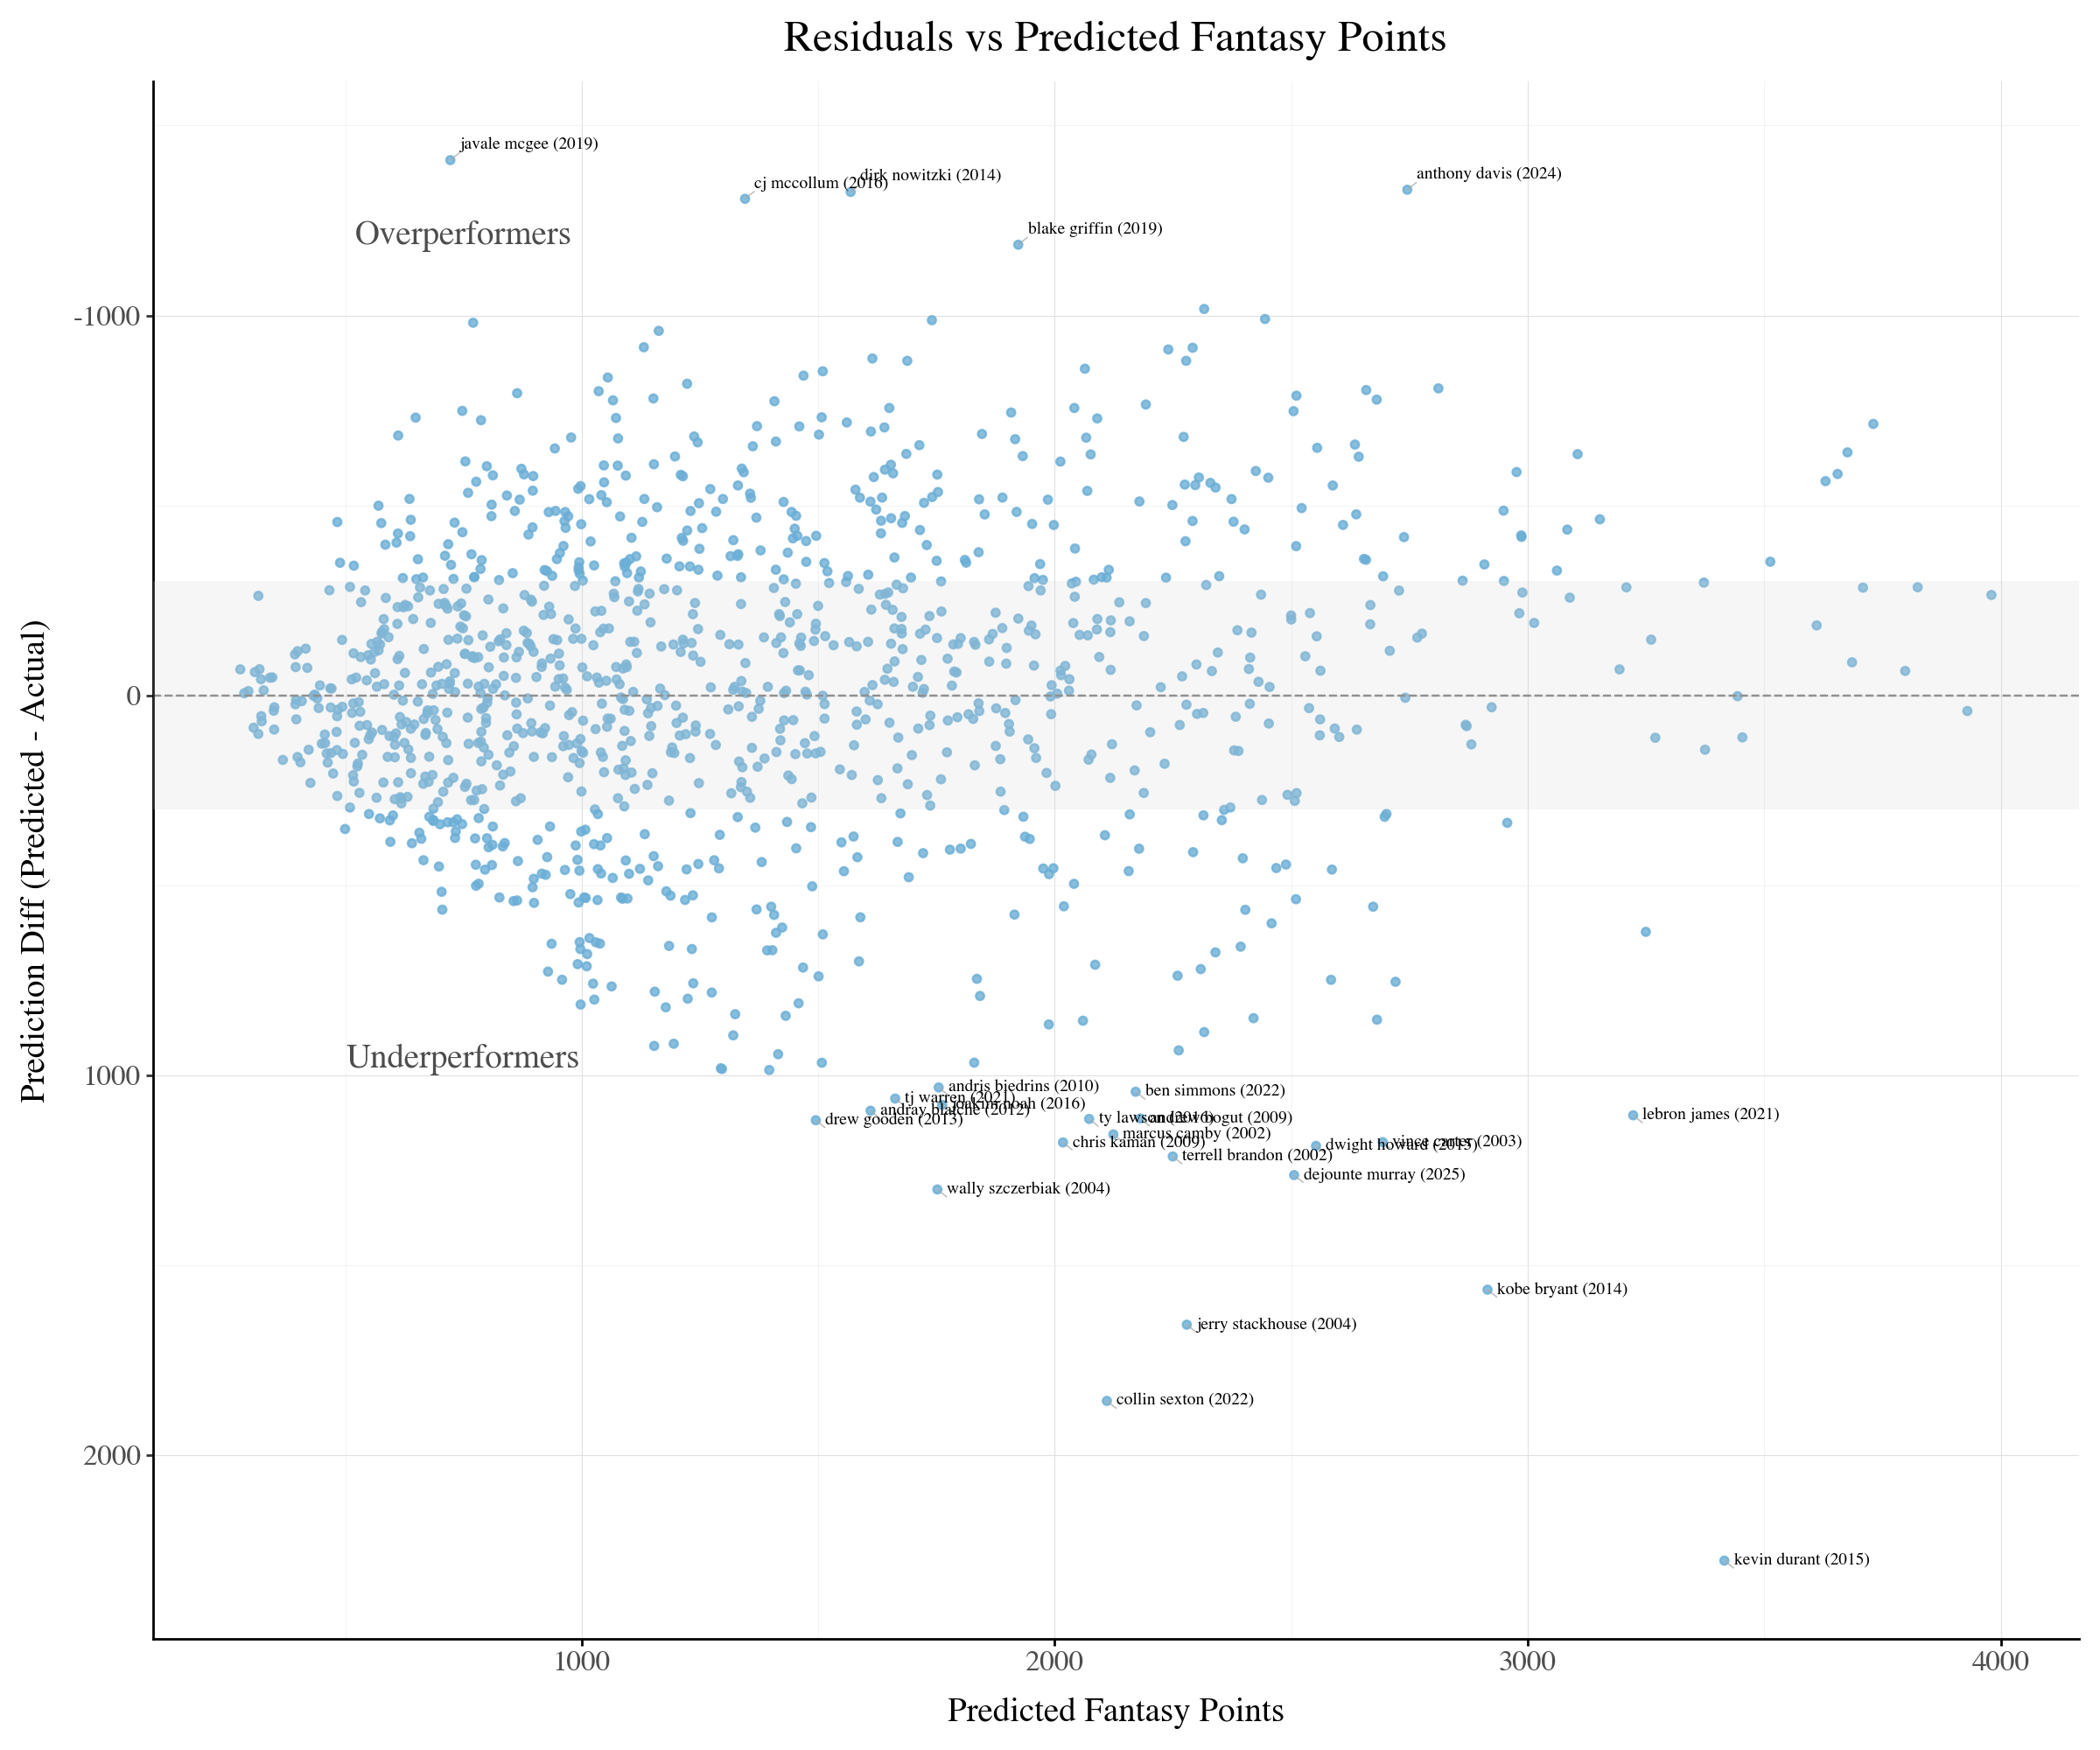

In [50]:
## Plot for Residuals vs Predicted Fantasy Points
plot_resid_vs_pred(results, COLOR_PALETTE, top_n=25).show()


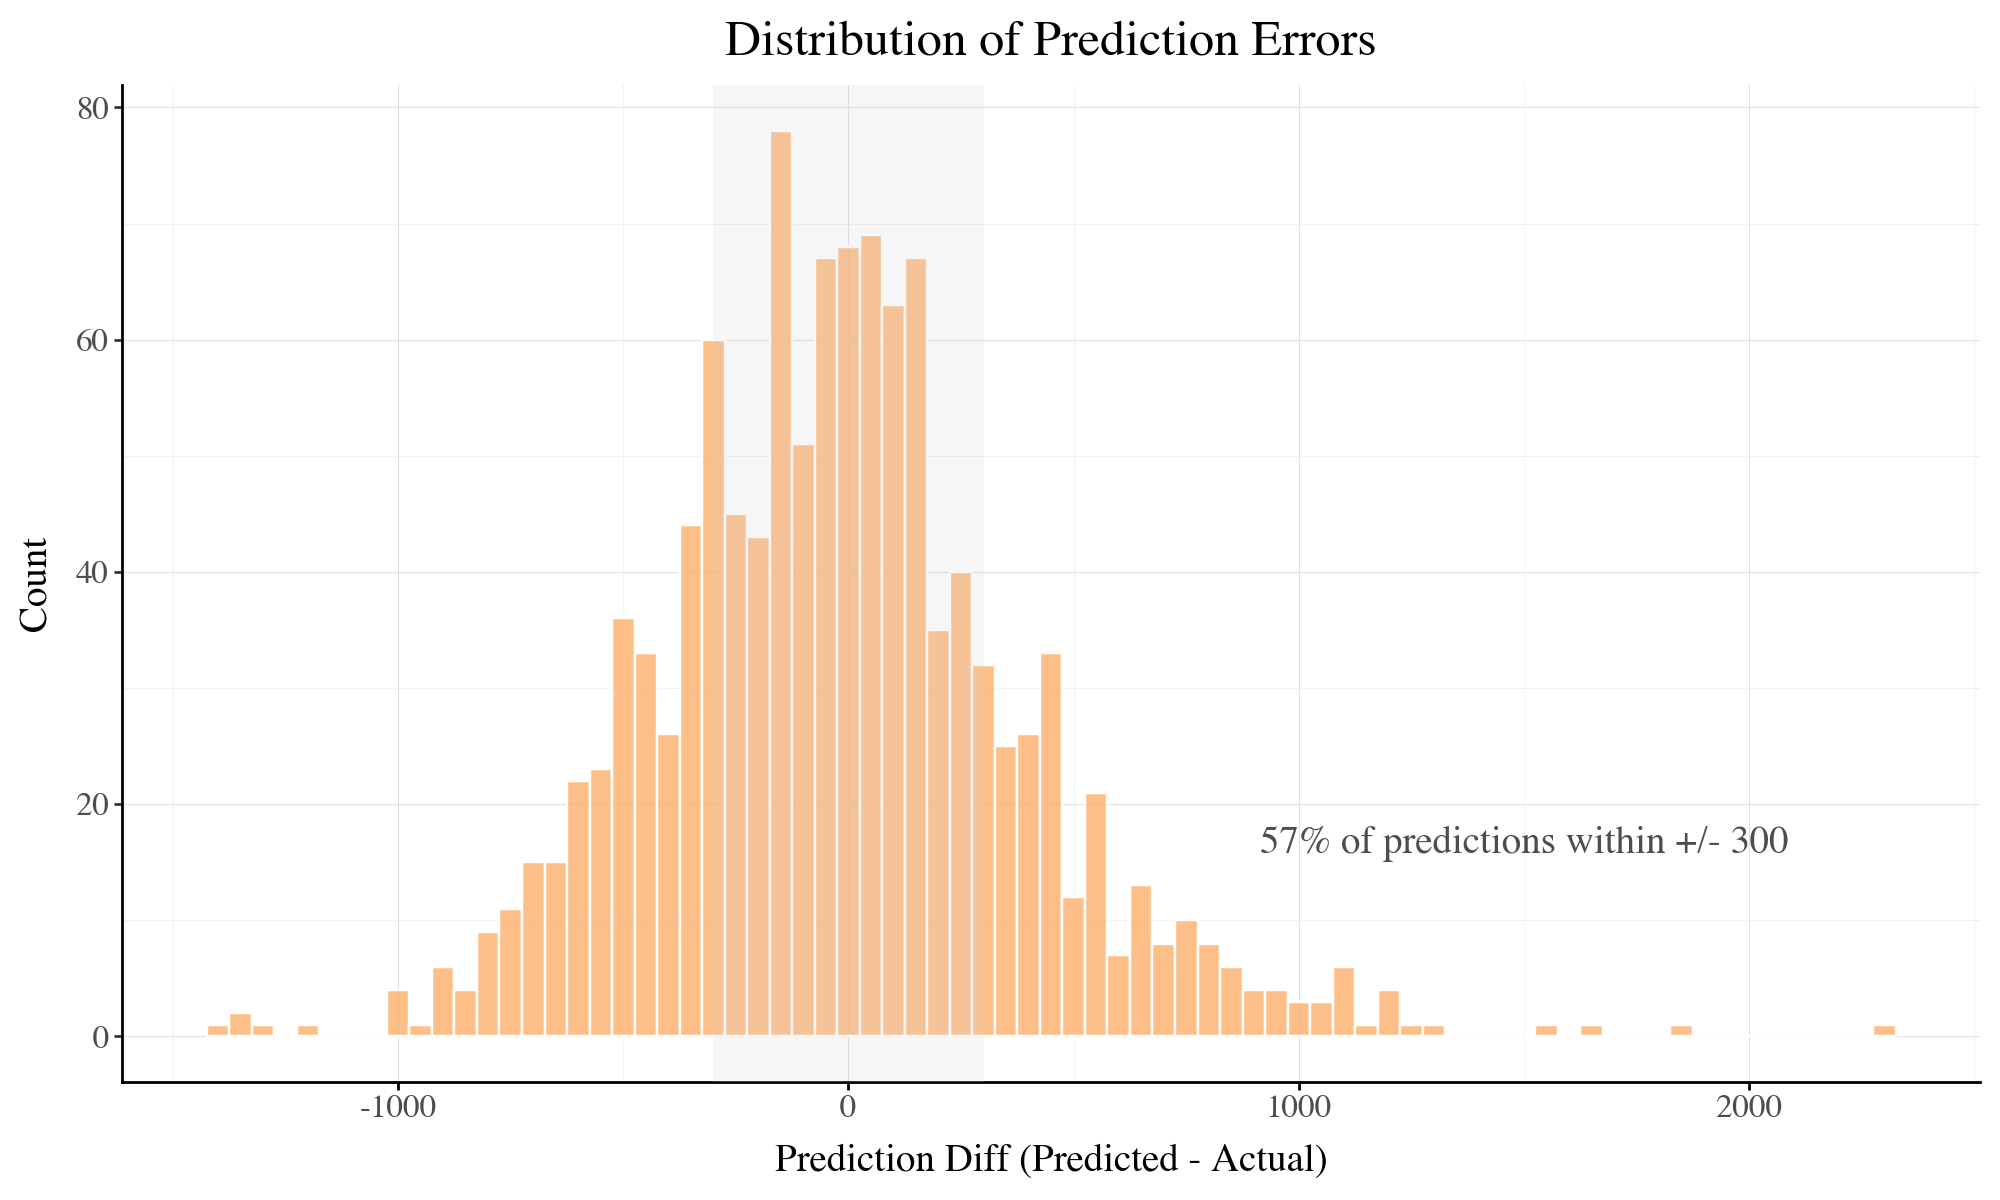

In [51]:
## Plot for Residuals Histogram
plot_resid_hist(results, COLOR_PALETTE, band=300).show()

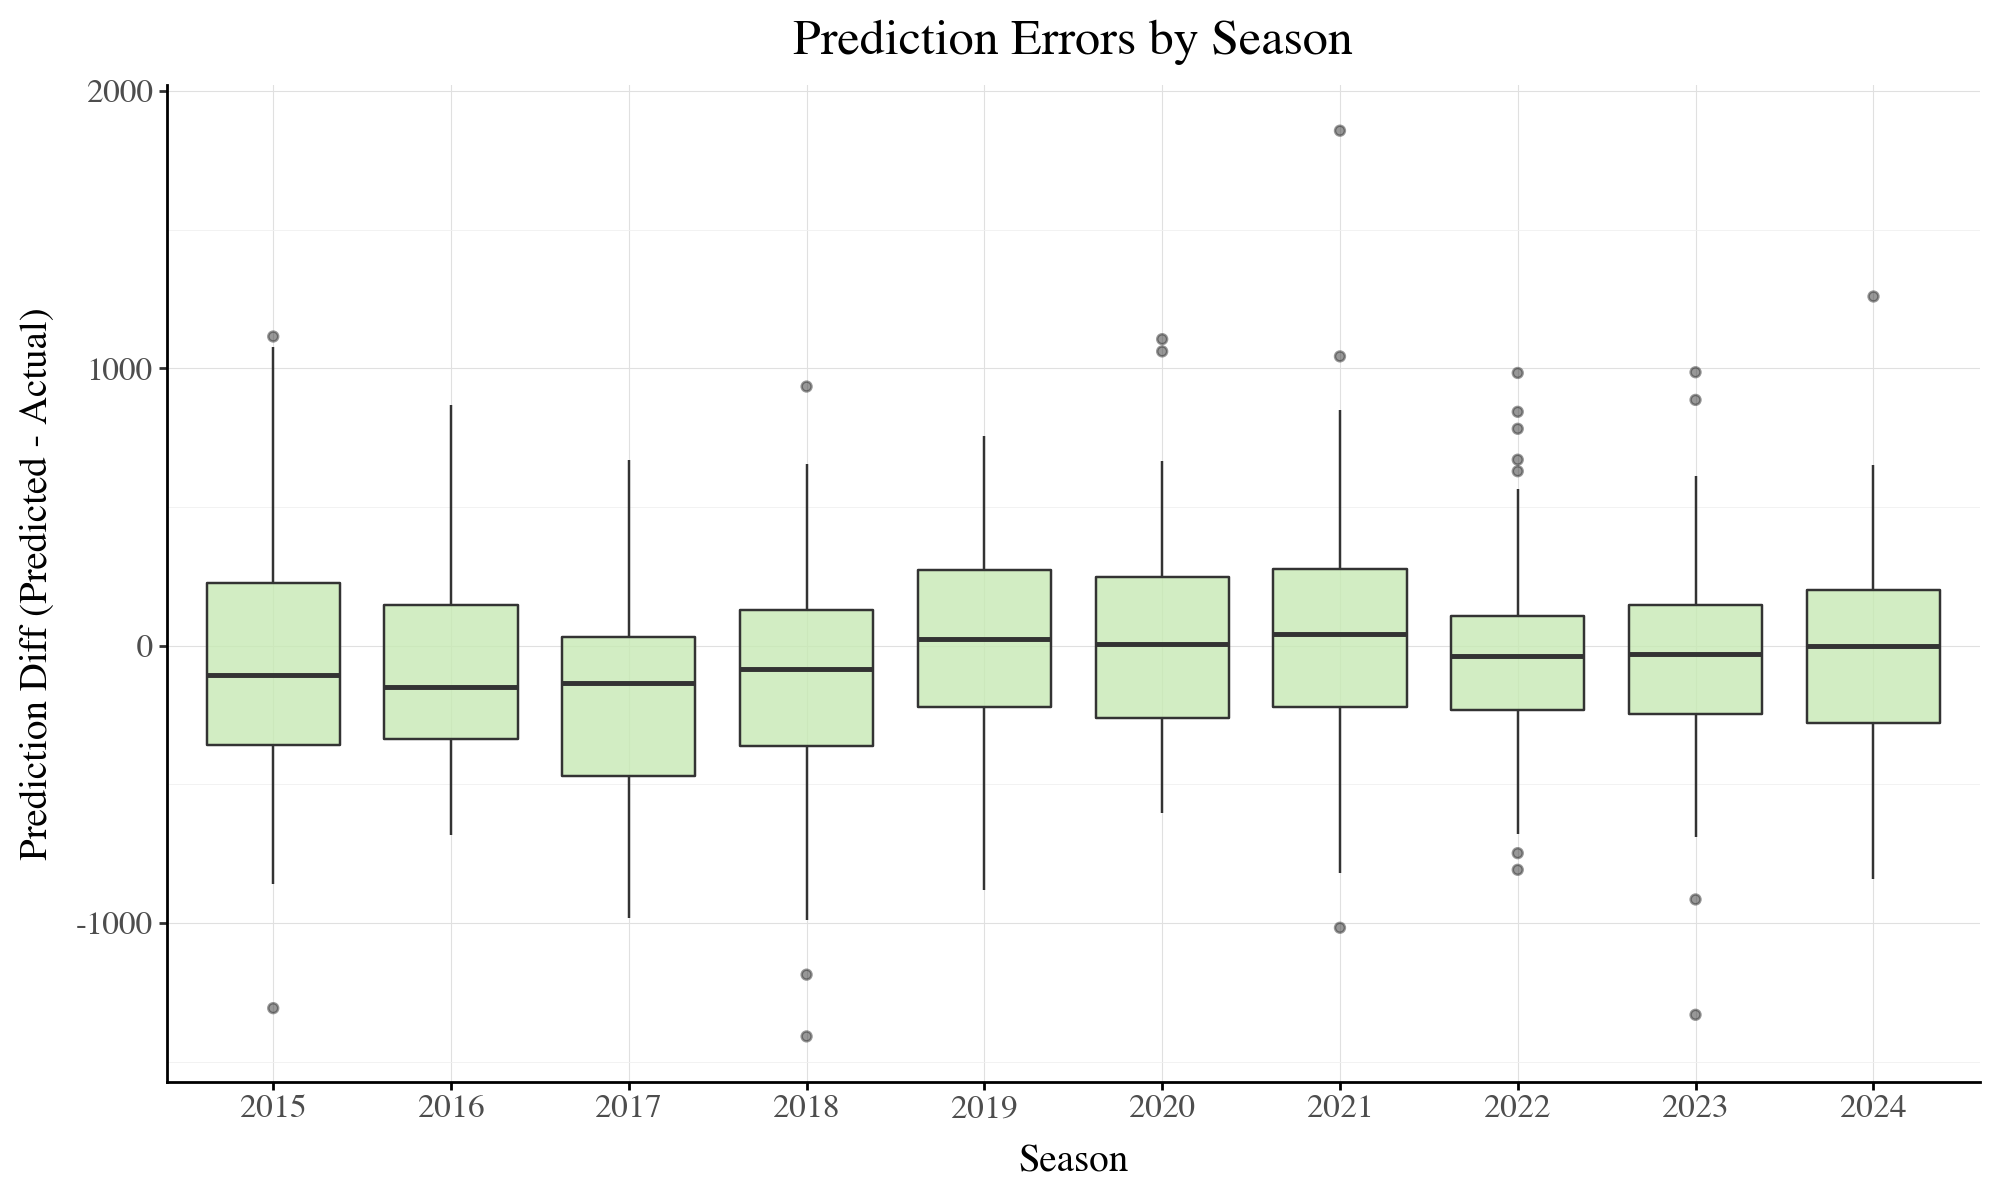

In [52]:
# Plotting prediction performance for the last 10 seasons
plot_recent_seasons(results, COLOR_PALETTE, n_seasons=10).show()

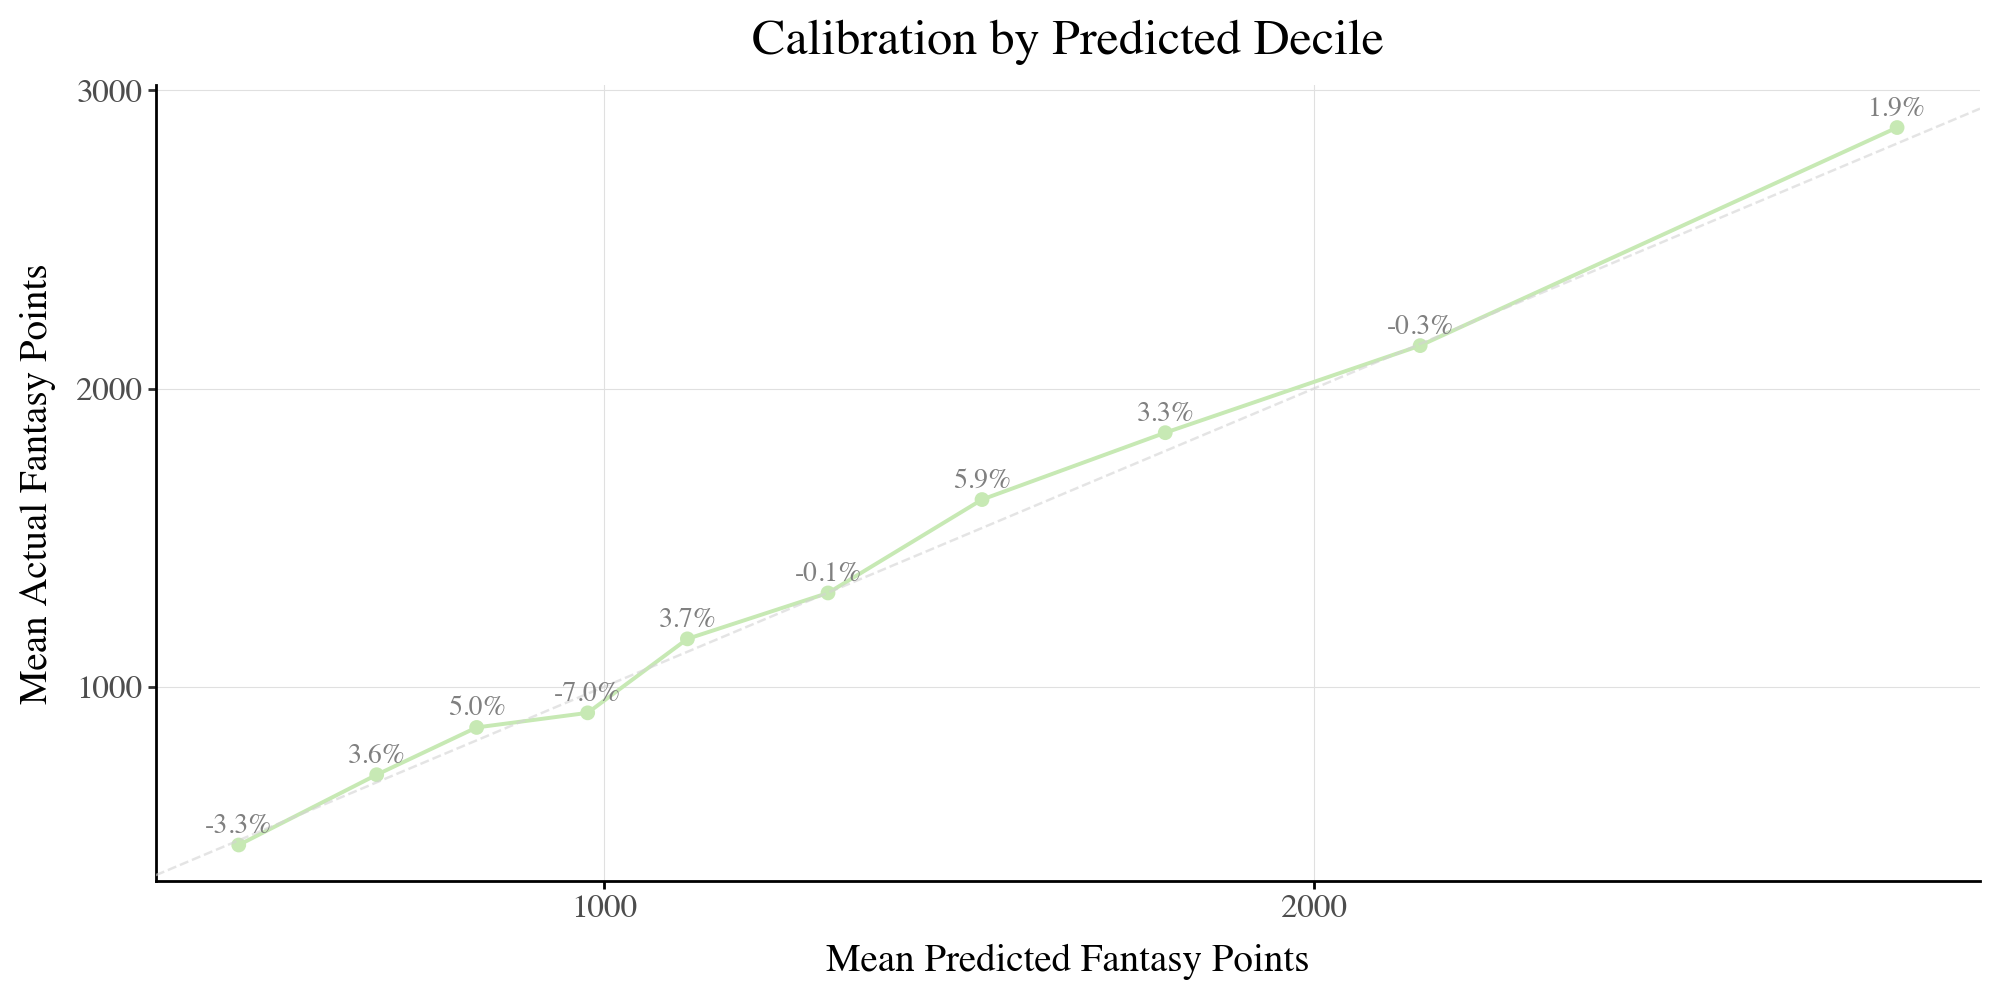

In [53]:
# Plotting performance by prediction decile
plot_decile_calib(results, COLOR_PALETTE).show()

In [54]:
# Making final predictions & adding them back onto the prediction dataframe
pred_values = final_model.predict(X_pred)

pred_df["predicted_fantasy_points"] = pred_values
pred_df["predicted_rank"] = pred_df["predicted_fantasy_points"].rank(method="min", ascending=False).astype(int)
pred_df["fantasy_points_rank"] = pred_df["fantasy_points"].rank(method="min", ascending=False).astype(int)

pred_eval_df = (pred_df[["player_name_clean", "age", "fantasy_points", "predicted_fantasy_points", "fantasy_points_rank", "predicted_rank"]].sort_values(
        by="predicted_rank", ascending=True)
)

pred_eval_df['predicted_diff'] = (pred_eval_df['fantasy_points_rank'] - pred_eval_df['predicted_rank']).astype(int)

pred_eval_df = pred_eval_df[pred_eval_df['predicted_rank'] <= 250].reset_index(drop=True)

display(pred_eval_df)

,player_name_clean,age,fantasy_points,predicted_fantasy_points,fantasy_points_rank,predicted_rank,predicted_diff
0,nikola jokic,30.0,4501.4,3550.265381,1,1,0
1,shai gilgeous alexander,26.0,4108.8,3247.755615,2,2,0
2,giannis antetokounmpo,30.0,3845.1,3107.687988,3,3,0
3,jayson tatum,27.0,3459.1,2979.268066,5,4,1
4,james harden,35.0,3557.7,2794.545410,4,5,-1
...,...,...,...,...,...,...,...
245,talen horton tucker,24.0,679.5,772.024597,309,246,63
246,matas buzelis,20.0,1378.1,769.550598,171,247,-76
247,keon johnson,23.0,1677.9,766.038513,114,248,-134
248,dayron sharpe,23.0,1115.5,762.805908,221,249,-28


In [55]:
# Write out final prediction evaluations to CSV
pred_eval_df.to_csv("nba_fantasy_predictions.csv", index=False)

In [ ]:
## TODO: Revise the process to scrape fantasy pros as needed based on changes to their site structure
## TODO: Place functions for blending positions & pulling fantasypros data into relevant .py files

In [57]:
# Creating function to assign position groups to players

def assign_position_group(df: pd.DataFrame):
    """
    Assigns a positional group based on the player's position.

    Parameters:
    df (pd.DataFrame): The DataFrame containing player data.
    position_col (str): The column name indicating the player's position.

    Returns:
    pd.DataFrame: The DataFrame with an additional 'position_group' column.
    """
    # Define position group mappings, Designated Hitters will default as infielders

    position_mapping = {
        "G": {"PG", "SG"},
        "W": {"SF", "PF"},
        "B": {"C"},
    }

    def map_position(pos):
        for group, positions in position_mapping.items():
            if pos in positions:
                return group
        return np.nan  # Unexpected values are set to NaN

    # Apply mapping function
    df["position_group"] = df['pos'].apply(map_position)

    return df

In [58]:
# List of player names that should keep their suffixes for fantasypros join (fantasypros includes suffixes for some players seemingly at random)
HOLDOUT_SUFFIX_NAMES = {
    "daron holmes ii",
    "dereck lively ii",
    "gary payton ii",
    "ronald holland ii"
}

def remove_suffixes(name):
    name_clean = name.strip().lower()
    if name_clean in HOLDOUT_SUFFIX_NAMES:
        return name  # Return original name if in holdout group
    # Remove common suffixes at the end of the name
    return re.sub(r'\s+(jr|sr|ii|iii|iv)$', '', name, flags=re.IGNORECASE).strip()

In [59]:
def scrape_fp_projections(url: str = FANTASYPROS_URL) -> pd.DataFrame:
    """
    Scrape the FantasyPros NBA overall rankings table and return as a DataFrame.
    Uses requests + BeautifulSoup to find the table with id="data".
    """
    # Fetch the page with a browser-like User-Agent
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")

    # Find the main data table (FantasyPros consistently uses id="data" on these pages)
    table = soup.find("table", {"id": "data"})
    if table is None:
        raise ValueError("Could not find table with id='data' on FantasyPros page.")

    # Extract header cells
    thead = table.find("thead")
    header_cells = thead.find_all("th")
    headers = [th.get_text(strip=True) for th in header_cells]

    # Extract body rows
    tbody = table.find("tbody")
    rows = []
    for tr in tbody.find_all("tr"):
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]
        # Some rows may be empty / separators
        if cells:
            rows.append(cells)

    # Build DataFrame
    df = pd.DataFrame(rows, columns=headers)

    return df

In [60]:
def clean_name_fp(name: str) -> str:
    """
    Convert a FantasyPros player string into a normalized 'player_name_clean'-style string.
    Example: 'Nikola Jokic (DEN - C)' -> 'nikola jokic'
    """
    if not isinstance(name, str):
        return ""

    # Remove accents (é -> e, etc.)
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")

    # Remove everything after the last closing parenthesis
    last_paren = name.rfind(")")
    if last_paren != -1:
        name = name[: last_paren + 1]

    # Drop anything in parentheses, e.g., " (DEN - C)"
    name = re.sub(r"\s*\(.*?\)", "", name)

    # Collapse whitespace & lowercase
    name = re.sub(r"\s+", " ", name).strip().lower()

    # Apply prior clean_name process to name
    name = clean_name(name)

    return name

In [61]:
# Function to extract first position from FantasyPros player string
def _extract_first_position(player_str):
    m = re.search(r'\(([^)]+)\)', str(player_str))
    if m:
        parts = m.group(1).split('-')
        if len(parts) > 1:
            positions = parts[1].split(',')
            return positions[0].strip()
    return None

def prepare_fantasypros_df() -> pd.DataFrame:
    """
    Scrape FantasyPros overall rankings and produce a cleaned dataframe
    with a `player_name_clean` column ready to join.
    """
    fp_raw = scrape_fp_projections(FANTASYPROS_URL)

    # Normalize column names to snake_case
    fp = fp_raw.copy()
    fp.columns = (
        fp.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("%", "pct")
    )

    # FantasyPros normally has a 'player' column
    if "player" not in fp.columns:
        raise ValueError(
            f"'player' column not found in FantasyPros DF. Columns: {fp.columns.tolist()}"
        )

    # Create player_name_clean
    fp["player_name_clean"] = fp["player"].apply(clean_name_fp)

    # Extract first position from the player string
    fp["position"] = fp["player"].apply(_extract_first_position)

    # Apply your existing name overrides if you want alignment with other sources
    # (assumes NAME_OVERRIDES dict is already defined in your notebook)
    if "NAME_OVERRIDES" in globals():
        fp["player_name_clean"] = fp["player_name_clean"].replace(NAME_OVERRIDES)

    # Try to identify a rank column and standardize its name
    rank_col_candidates = [c for c in fp.columns if "rank" in c or c == "rk"]
    if rank_col_candidates:
        fp = fp.rename(columns={rank_col_candidates[0]: "fp_rank"})

    return fp

In [62]:
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3

def build_final_projections(merged_projections, MODEL_WEIGHT: float, PROJECTION_WEIGHT: float) -> pd.DataFrame:
    """
    Creates final blended projections by combining model predictions with site projections.

    Parameters:
        merged_projections (pd.DataFrame): DataFrame with 'predicted_fantasy_points' and 'projected_fantasy_points'.
        MODEL_WEIGHT (float): Weight for model predictions.
        PROJECTION_WEIGHT (float): Weight for site projections.

    Returns:
        pd.DataFrame: DataFrame with new 'final_projection' column.
    """
    df = merged_projections.copy()

    # Fill missing values in both columns from the other
    df["predicted_fantasy_points"] = df["predicted_fantasy_points"].fillna(df["projected_fantasy_points"])
    df["projected_fantasy_points"] = df["projected_fantasy_points"].fillna(df["predicted_fantasy_points"])

    # Weighted final projection
    df["final_projection"] = (
        df["predicted_fantasy_points"] * MODEL_WEIGHT +
        df["projected_fantasy_points"] * PROJECTION_WEIGHT
    )

    return df

In [63]:
# Removing suffixes from player names for joining with FantasyPros data
# Fantasypros does not include suffixes in player names
pred_df["player_name_clean"] = pred_df["player_name_clean"].apply(remove_suffixes)

In [64]:
fp_df = prepare_fantasypros_df()
fp_df.head()

,player,pts,reb,ast,blk,stl,fgpct,ftpct,3pm,to,gp,min,ftm,2pm,a/to,pf,player_name_clean,position
0,Shai Gilgeous-Alexander(OKC - PG),"1,334",182,259,34,56,.548,.892,81,83,42,"1,401",345,373,3.12,87,shai gilgeous alexander,PG
1,"Tyrese Maxey(PHI - PG,SG)","1,199",173,269,39,83,.469,.879,142,99,40,"1,578",217,278,2.72,85,tyrese maxey,PG
2,"Jaylen Brown(BOS - SG,SF)DTD","1,162",256,185,15,37,.487,.791,85,145,39,"1,331",227,340,1.28,117,jaylen brown,SG
3,"Donovan Mitchell(CLE - PG,SG)","1,159",193,227,10,60,.485,.840,153,120,40,"1,360",204,248,1.89,98,donovan mitchell,PG
4,"Luka Doncic(LAL - PG,SG)","1,138",262,295,18,53,.467,.787,117,150,34,"1,234",307,240,1.97,92,luka doncic,PG


In [65]:
# Assigning a random value between 900 and 1100 for testing purposes
fp_df['projected_fantasy_points'] = np.random.randint(900, 1100, size=len(fp_df))

In [66]:
# Merging model predictions with fantasy pros projections
merged_projections = pd.merge(
    pred_df,
    fp_df[["player_name_clean", "projected_fantasy_points", "position"]],
    on="player_name_clean",
    how="outer",
)

# Replacing any missing "pos" values with "position" from fantasy pros
merged_projections["pos"] = merged_projections["pos"].astype(str)
merged_projections["pos"] = merged_projections["pos"].replace("nan", np.nan)
merged_projections["pos"] = merged_projections["pos"].fillna(merged_projections["position"])

In [67]:
# Creating final projections by blending model and fantasy pros projections
blended_df = build_final_projections(
    merged_projections,
    MODEL_WEIGHT,
    PROJECTION_WEIGHT,
)

# # Assign position groups to players
blended_df = assign_position_group(blended_df)

# Dropping rows where "position_group" is NaN, these are generally G-League or non-roster players
blended_df = blended_df[blended_df["position_group"].notna()]

# Ranking each player in their position group based on final blended projection
blended_df["position_rank"] = (blended_df.groupby("position_group")["final_projection"] 
    .rank(method="min", ascending=False).astype(int)
)

# Creating draft board based on position group pools
g_board = blended_df[(blended_df["position_group"] == "G") & (blended_df["position_rank"] <= g_pool)]
w_board = blended_df[(blended_df["position_group"] == "W") & (blended_df["position_rank"] <= w_pool)]
b_board = blended_df[(blended_df["position_group"] == "B") & (blended_df["position_rank"] <= b_pool)]

draft_df = pd.concat([g_board, w_board, b_board]).reset_index(drop=True)

In [68]:

POS_DAMPENING_MAP = {
    "G": 1.00,    
    "W": 1.00,   
    "B": 1.00,   
}

def apply_position_dampening(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    value_col: str = "relative_value",
    dampening_map: dict[str, float] | None = None,
    adjustment_col: str = "pos_adjustment",
) -> pd.DataFrame:
    """
    Apply position-based dampening multipliers to a value column.

    This is intended to reduce or increase the influence of certain position groups
    on final rankings (e.g., to avoid model-driven over-inflation of one group).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing position groups and a value column.
    position_col : str, default "position_group"
        Column containing the position grouping (e.g., "IF", "OF", "P", "C").
    value_col : str, default "relative_value"
        Column containing the pre-dampened value metric to adjust.
    dampening_map : dict[str, float] | None, default None
        Mapping from position group -> multiplier. Unspecified groups default to 1.0.
        Example: {"P": 0.85, "C": 0.95, "IF": 1.05, "OF": 1.10}
    adjustment_col : str, default "pos_adjustment"
        Name of the multiplier column to create (kept for transparency).

    Returns
    -------
    pd.DataFrame
        Copy of `df` with `adjustment_col` and dampened `value_col`.
    """
    out = df.copy()

    if dampening_map is None:
        dampening_map = {}

    out[adjustment_col] = out[position_col].map(dampening_map).fillna(1.0).astype(float)
    out[value_col] = out[value_col] * out[adjustment_col]

    return out

def calculate_relative_value(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    projection_col: str = "final_projection",
    vorp_cutoff: float = 0.66,
    z_weight: float = 0.50,
    vorp_weight: float = 0.50,
    vorp_scale: float = 1,
    dampening_map: dict[str, float] | None = None,
) -> pd.DataFrame:
    """
    Compute an NFL-style Relative Value metric for MLB using:
      - Z-score scaled projection within each position group
      - VORP (Value Over Replacement Player) within each position group
      - optional position dampening multipliers

    This assumes the player pool has *already* been filtered to your top-N cutoffs
    (as you noted your pipeline already does).

    Parameters
    ----------
    df : pd.DataFrame
        Player pool dataframe.
    position_col : str, default "position_group"
        Position grouping column.
    projection_col : str, default "final_projection"
        Projection column used for rankings and value.
    vorp_cutoff : float, default 0.66
        Percentile (as a fraction of the position cutoff pool) that defines the "replacement" rank.
        Example: 0.66 means replacement rank is roughly the 66th percentile of the pool
        (implemented as round(n_in_group * vorp_cutoff), min 1).
    z_weight : float, default 0.50
        Weight applied to the z-score scaled projection component.
    vorp_weight : float, default 0.50
        Weight applied to the VORP component (after scaling).
    vorp_scale : float, default 2.25
        Multiplier applied to VORP to increase its spread before blending.
    dampening_map : dict[str, float] | None, default None
        Optional dampening multipliers per position group.

    Returns
    -------
    pd.DataFrame
        Dataframe with:
        - position_rank
        - replacement_value
        - z_score_value
        - vorp
        - relative_value (dampened if provided)
        - overall_ranking (dense)
    """
    required = {position_col, projection_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    out = df.copy()

    # -----------------------------
    # Position ranks by projection
    # -----------------------------
    out["position_rank"] = (
        out.groupby(position_col)[projection_col]
        .rank(method="dense", ascending=False)
        .astype(int)
    )

    # -----------------------------
    # Replacement value per position
    # (based on *current player pool size*)
    # -----------------------------
    replacement_rows = []

    for pos, g in out.groupby(position_col, sort=False):
        n = len(g)
        # replacement rank is fraction of the pool; ensure >= 1
        repl_rank = max(1, int(round(n * vorp_cutoff)))

        repl_val = (
            g.loc[g["position_rank"] == repl_rank, projection_col]
            .head(1)
            .squeeze()
        )

        # If exact rank not found for some reason, fallback to nth best
        if pd.isna(repl_val):
            repl_val = g.sort_values(projection_col, ascending=False)[projection_col].iloc[
                min(repl_rank - 1, n - 1)
            ]

        replacement_rows.append({position_col: pos, "replacement_value": float(repl_val)})

    replacement_df = pd.DataFrame(replacement_rows)
    out = out.merge(replacement_df, on=position_col, how="left")

    # -----------------------------
    # Z-score scaled projection within position
    # -----------------------------
    stats = (
        out.groupby(position_col)[projection_col]
        .agg(group_mean="mean", group_std="std")
        .reset_index()
    )
    out = out.merge(stats, on=position_col, how="left")

    safe_std = out["group_std"].replace(0, np.nan)
    z = (out[projection_col] - out["group_mean"]) / safe_std
    z = z.fillna(0.0)

    out["z_score_value"] = z * out[projection_col]

    # -----------------------------
    # VORP + blend
    # -----------------------------
    out["vorp"] = out[projection_col] - out["replacement_value"]

    out["relative_value"] = (
        (z_weight * out["z_score_value"])
        + (vorp_weight * (out["vorp"] * vorp_scale))
    )

    # -----------------------------
    # Dampening by position group
    # -----------------------------
    out = apply_position_dampening(
        out,
        position_col=position_col,
        value_col="relative_value",
        dampening_map=dampening_map,
        adjustment_col="pos_adjustment",
    )

    # -----------------------------
    # Enforce 1:1 ordering with projections inside each position group
    # -----------------------------
    out = out.sort_values([position_col, projection_col], ascending=[True, False])

    # For each group: sort relative_value desc and assign in projection order
    aligned_vals = []
    for pos, g in out.groupby(position_col, sort=False):
        sorted_vals = np.sort(g["relative_value"].to_numpy())[::-1]
        aligned_vals.append(pd.Series(sorted_vals, index=g.index))

    out["relative_value"] = pd.concat(aligned_vals).sort_index()

    # -----------------------------
    # Overall ranking
    # -----------------------------
    out["overall_ranking"] = (
        out["relative_value"].rank(method="dense", ascending=False).astype(int)
    )

    # Cleanup intermediate stats columns if you want
    out = out.drop(columns=["group_mean", "group_std"])

    # Sorting final output by overall ranking
    out = out.sort_values("overall_ranking").reset_index(drop=True)

    return out

In [69]:
# Ranking players based on their relative value
value_df = calculate_relative_value(
    draft_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.66,
    z_weight=0.50,
    vorp_weight=0.50,
    vorp_scale=1,
    dampening_map=POS_DAMPENING_MAP,
)